## 목차

1. 프로젝트 개요  
  1.1. 문제 정의 및 목표  
  1.2. 데이터셋 및 감성 라벨 특징  
  1.3. Full Fine-Tuning 과 PEFT  

2. 환경 설정 및 데이터 준비  
  2.1. 환경 설정 및 라이브러리 임포트  
  2.2. 데이터 로드 및 도메인 선택  
  2.3. 전처리 및 학습/검증/테스트 분할  
  2.4. 라벨 분포·리뷰 길이 등 기초 분석  

3. Full Fine-Tuning 기반 감성 분석 모델  
  3.1. 베이스 모델 및 토크나이저 정의  
  3.2. 데이터 토크나이징 및 데이터셋 구성  
  3.3. 학습 설정(하이퍼파라미터, 지표 함수)  
  3.4. Full Fine-Tuning 학습  
  3.5. Full Fine-Tuning 모델 평가 및 저장  

4. PEFT 기반 감성 분석 모델  
  4.1. PEFT(LoRA 등) 개념 및 적용 전략  
  4.2. PEFT 설정 및 베이스 모델 래핑  
  4.3. PEFT 학습 설정 및 학습  
  4.4. PEFT 모델 평가 및 어댑터 저장  

5. 실험 결과 비교 및 분석  
  5.1. 학습 시간·성능·모델 크기 비교  
  5.2. 결과 해석 및 장단점 분석  
  5.3. 한계점 및 추가 실험 아이디어  
  5.4. 결론

## 1. 프로젝트 개요

### 1.1. 문제 정의 및 목표

- 이번 미션의 목표는 쇼핑몰·SNS 리뷰 텍스트를 입력으로 받아, 해당 리뷰의 감성(부정/중립/긍정)을 자동으로 분류하는 모델을 구현하고 비교하는 것이다.

- 이 미션에서 핵심적으로 달성해야 할 목표는 다음과 같다.
    - AI Hub 기반 리뷰 데이터셋을 활용해, 선택한 도메인(패션/화장품/가전/IT/생활 중 1개 이상)에 대해 감성 분석 모델 파이프라인(로드 → 전처리 → 학습 → 평가)을 처음부터 끝까지 구현한다.

    - 같은 데이터와 유사한 조건에서 `Full Fine-Tuning` 방식과 `PEFT`(예: LoRA) 방식을 각각 적용하여, 학습 시간, 감성 분석 성능(예: Accuracy, F1 등), 저장된 모델/어댑터 파일의 크기, 를 정량적으로 비교한다.

    - 위 결과를 통해 “리뷰 감성 분석 문제에서, 어떤 상황에 Full Fine-Tuning이 더 적합하고, 어떤 상황에 PEFT가 더 효율적인지”를 해석한다.

### 1.2. 데이터셋 및 감성 라벨 특징

- 이번 미션에서 사용하는 데이터셋은 AI Hub의 ‘속성기반 감정분석 데이터’를 가공한 쇼핑몰·SNS 리뷰 모음으로, 패션·화장품·가전·IT기기·생활 5가지 도메인의 리뷰가 포함되어 있다. 이 중에서 하나 이상의 도메인을 선택해 감성 분석 모델을 학습·평가하게 된다.

- 데이터는 JSON 형식으로 제공되며, 한 파일에 여러 개의 리뷰가 들어 있고, 각 리뷰는 다음과 같은 주요 필드를 가진다.
    - RawText: 실제 리뷰 텍스트가 저장된 필드로, 모델의 입력이 되는 문장(또는 문단)이다.
    - GeneralPolarity: 리뷰 전체에 대한 감성 레이블로, 다음과 같은 3개 값 중 하나를 가진다.
        - -1: 부정(negative)
        - 0: 중립(neutral)
        - 1: 긍정(positive)

- 모델 학습을 위해서는 이 GeneralPolarity 값을 모델이 다루기 좋은 정수 클래스 인덱스(예: 0, 1, 2) 로 변환하여 사용한다. 예를 들어 -1 → 0, 0 → 1, 1 → 2와 같이 매핑하면, 3클래스 분류 문제로 자연스럽게 설정할 수 있다.
​
- 또한, 리뷰 길이 분포(평균·최대 토큰 수 등)와 각 감성 라벨의 개수 비율을 간단히 확인해 두면, 패딩/최대 길이 설정과 데이터 불균형 여부를 판단하는 데 도움이 된다. 이 정보는 이후 하이퍼파라미터 설정(최대 토큰 길이, 배치 크기 등)과 성능 해석(어떤 라벨에서 성능이 떨어지는지)에도 직접적으로 연결된다.

### 1.3. Full Fine-Tuning 과 PEFT

- 이번 미션에서는 같은 리뷰 감성 분석 문제에 대해 두 가지 학습 방식(Full Fine-Tuning, PEFT)을 적용하고, 아래 세 가지 축을 중심으로 비교·분석한다.
​
1. 학습 시간 관점
    - 동일(또는 유사)한 데이터셋, epoch 수, 배치 크기 등의 조건에서 두 방식을 학습시킨 뒤, 전체 학습 소요 시간과 epoch당 평균 시간을 비교한다.
    - Full Fine-Tuning은 모델 전체 파라미터를 업데이트하고, PEFT는 일부 모듈(예: LoRA 어댑터)만 학습하므로, 실제로 학습 속도에 어느 정도 차이가 나는지 정량적으로 확인하는 것이 목표다.

2. 성능(정확도·F1 등) 관점
    - 동일 테스트 세트에 대해 두 방식으로 학습된 모델의 정확도(Accuracy), 필요하다면 F1-score 등을 계산해, 감성 분류 성능을 비교한다.
    - 파라미터 수와 학습 범위가 다른 두 접근법이 실제 리뷰 감성 분석에서 성능 손실 없이 경량화가 가능한지, 혹은 Full Fine-Tuning이 더 우수한지를 실험적으로 확인한다.

3. 모델/가중치 파일 크기 관점
    - 학습 완료 후, Full Fine-Tuning으로 학습된 전체 모델 가중치 파일 크기와 PEFT 방식에서 저장되는 어댑터(추가 가중치) 파일 크기를 각각 측정·비교한다.
    - 이를 통해, 실제 서비스나 배포 상황에서 저장 공간, 전송 비용, 버전 관리 측면에서 PEFT가 갖는 이점이 어느 정도인지 살펴본다.

- 이 세 관점(시간·성능·크기)에서 시각화를 통해 “리소스가 제한된 환경에서 PEFT가 얼마나 유용한지”, “성능을 극대화해야 할 때 Full Fine-Tuning의 의미는 무엇인지”를 해석하는 것이 해당 프로젝트의 핵심 목표이다.

## 2. 환경 설정 및 데이터 준비

### 2.1. 환경 설정 및 라이브러리 임포트

- 필요한 라이브러리(transformers, peft, datasets 또는 pandas, sklearn, torch 등)를 임포트하고, GPU 사용 여부를 확인한다.

- 랜덤 시드를 고정하여 실험 재현성을 확보하고, 로그 출력 수준이나 경로 설정 등 이후 단계에서 공통으로 사용할 기본 환경을 구성한다.

In [1]:
import os
import json
import random
import numpy as np
import torch
from sklearn.model_selection import train_test_split
import pandas as pd

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


### 2.2. 데이터 로드 및 도메인 선택

- 로컬 디렉터리에 저장된 AI Hub 기반 IT 기기(SNS) 리뷰 JSON 파일들을 재귀적으로 탐색한다.

- 각 파일에서 `RawText`와 `GeneralPolarity` 필드를 읽어와, 라벨이 -1, 0, 1인 샘플만 남기고 0, 1, 2로 재매핑해 감성 분석용 텍스트·라벨 쌍을 구성한다.

- 해당 과정에서 IT 기기 도메인만 선택해 이후 전처리와 학습에 사용할 데이터프레임을 만든다.

In [2]:
# 1. 데이터 경로(IT 기기 리뷰만 사용)
data_dir = "/home/kmw/github/mission13/dataset/review-sentiment-analysis/SNS/04. IT기기"

# 2. JSON 파일 경로 수집
json_paths = []
for root, _, files in os.walk(data_dir):
    for file in files:
        if file.endswith(".json"):
            json_paths.append(os.path.join(root, file))

# 3. JSON 파싱 및 필요한 데이터(GeneralPolarity, RawText) 수집
data = []

for path in json_paths:
    with open(path, 'r', encoding='utf-8') as f:
        try:
            items = json.load(f)
            for item in items:
                polarity = item.get("GeneralPolarity", None)
                text = item.get("RawText", None)

                if polarity is not None and text:  # 둘 다 있어야 추가
                    polarity = int(polarity)
                    if polarity in [-1, 0, 1]:
                        data.append({
                            "text": text,
                            "label": polarity + 1  # -1 → 0, 0 → 1, 1 → 2
                        })
        except Exception:
            continue  # 형식 이상한 파일은 무시하고 넘어감

# 4. 데이터프레임으로 변환
df = pd.DataFrame(data)
df = df.dropna().drop_duplicates()

In [3]:
df.head()

,text,label
0,얼마전에 휴대폰이 화장실에서 침수되는 바람에 고장이 나고 말았어요 ㅜㅜ 그래서 휴대...,1
1,접는 휴대폰이 나오고 부터 이런 디자인의 핸드폰이 갖고 싶었는데 처음 나올때는 품질...,2
2,이제까지 다른 회사 제품의 스마트폰만 계속 사용해 왔어요. 그런데 이렇게 접는 핸드...,0
3,이제까지 휴대폰을 사용하면서 항상 애용하는 브랜드예요. 그러다 보니 운영체제나 사용...,2
4,폰 기종을 바꾸니까 적응하는게 정말 낯설어요.그래도 오랜만에 예전에 쓰던 기종으로 ...,2


In [4]:
print(df["label"].value_counts())

label
2    2251
1    1451
0     706
Name: count, dtype: int64


### 2.3 전처리 및 학습/검증/테스트 분할

- 판다스 데이터프레임을 Hugging Face `Dataset` 형식으로 변환하고, 데이터를 학습(train), 검증(validation), 테스트(test) 세 부분으로 분할한다.  

- 먼저 전체 데이터의 일부를 테스트 세트로 떼어낸 뒤, 남은 학습 세트에서 다시 검증 세트를 분리해 하이퍼파라미터 튜닝과 최종 평가에 사용할 데이터 구성을 완성한다.

In [5]:
from datasets import Dataset

# 1차: 원본 df에서 train/test 분할
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=SEED,
    stratify=df["label"],
)

# 2차: train 을 다시 train/val 분할
train_df, val_df = train_test_split(
    train_df,
    test_size=0.1,
    random_state=SEED,
    stratify=train_df["label"],
)

In [6]:
from transformers import AutoTokenizer

model_name = "beomi/KcELECTRA-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)


def preprocess(example):
    tokenized = tokenizer(
        example["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )
    tokenized["text"] = example["text"]
    return tokenized

### 2.4. 라벨 분포·리뷰 길이 등 기초 분석

- 각 데이터 분할(train/validation/test)에 대해 감성 라벨 분포와 리뷰 길이(문자 수 기준)를 간단히 살펴본다.

- 이를 통해 데이터 불균형 여부와 적절한 최대 토큰 길이를 파악하고, 이후 성능 분석 시 어떤 라벨에서 오류가 많이 나는지 해석할 기반 정보를 확보한다.

In [7]:
def describe_split(name, df_split):
    print(f"=== {name} split ===")
    print("Label distribution:")
    print(df_split["label"].value_counts(normalize=True))
    lengths = df_split["text"].str.len()
    print("Length mean:", lengths.mean(), "max:", lengths.max())

In [8]:
# 분포/길이 확인
describe_split("Train", train_df)
describe_split("Validation", val_df)
describe_split("Test", test_df)

describe_split("Train", train_df)
describe_split("Validation", val_df)
describe_split("Test", test_df)

=== Train split ===
Label distribution:
label
2    0.510558
1    0.329341
0    0.160101
Name: proportion, dtype: float64
Length mean: 479.54932240781596 max: 1000
=== Validation split ===
Label distribution:
label
2    0.509915
1    0.328612
0    0.161473
Name: proportion, dtype: float64
Length mean: 468.5325779036827 max: 998
=== Test split ===
Label distribution:
label
2    0.511338
1    0.328798
0    0.159864
Name: proportion, dtype: float64
Length mean: 482.4671201814059 max: 1000
=== Train split ===
Label distribution:
label
2    0.510558
1    0.329341
0    0.160101
Name: proportion, dtype: float64
Length mean: 479.54932240781596 max: 1000
=== Validation split ===
Label distribution:
label
2    0.509915
1    0.328612
0    0.161473
Name: proportion, dtype: float64
Length mean: 468.5325779036827 max: 998
=== Test split ===
Label distribution:
label
2    0.511338
1    0.328798
0    0.159864
Name: proportion, dtype: float64
Length mean: 482.4671201814059 max: 1000


In [9]:
# HF Dataset으로 변환
from datasets import Dataset, DatasetDict

dataset = DatasetDict({
    "train": Dataset.from_pandas(train_df),
    "validation": Dataset.from_pandas(val_df),
    "test": Dataset.from_pandas(test_df),
})

## 3. Full Fine-Tuning 기반 감성 분석 모델

### 3.1. 베이스 모델 및 토크나이저 정의

- 한국어 쇼핑몰 리뷰 감성 분석에 사용할 사전학습 언어모델과 토크나이저를 정의한다.

- `beomi/KcELECTRA-base`는 한국어에 특화된 ELECTRA 기반 모델로, 여기에 3개 클래스(부정/중립/긍정)를 분류하는 헤드를 얹어 사용한다.

- 토크나이저는 이후 전처리 단계에서 각 리뷰 문장을 토큰 ID와 어텐션 마스크로 변환할 때 재사용된다.

In [10]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "beomi/KcELECTRA-base"

# 한국어 ELECTRA 토크나이저 및 분류용 모델 로드
tokenizer = AutoTokenizer.from_pretrained(model_name)

model_ft = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3,  # negative / neutral / positive
)
model_ft.to(device)

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30000, 768, padding_idx=3)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): L

### 3.2. 데이터 토크나이징 및 데이터셋 구성

- 앞에서 분할한 train/validation/test 세트를 KcELECTRA 토크나이저로 토크나이징해 `input_ids`, `attention_mask`, `labels` 형식의 텐서 데이터셋으로 변환한다.

- 각 리뷰 텍스트는 최대 길이 128 토큰으로 잘라 padding을 적용하며, 원본 텍스트(`text`)는 이후 오류 분석을 위해 함께 보존한다.

In [11]:
def preprocess(example):
    tokenized = tokenizer(
        example["text"],
        truncation=True,
        padding="max_length",
        max_length=128,
    )
    # 나중에 에러 분석에서 원문을 보기 위해 text도 함께 유지
    tokenized["text"] = example["text"]
    return tokenized

# train / validation / test 전체에 토크나이징 적용
tokenized_dataset = dataset.map(preprocess, batched=True)

# Trainer가 기대하는 컬럼 이름으로 변경
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")

# PyTorch 텐서 형식으로 세팅
tokenized_dataset.set_format(
    type="torch",
    columns=["text", "input_ids", "attention_mask", "labels"],
)

Map:   0%|          | 0/3173 [00:00<?, ? examples/s]

Map:   0%|          | 0/353 [00:00<?, ? examples/s]

Map:   0%|          | 0/882 [00:00<?, ? examples/s]

### 3.3. 학습 설정(하이퍼파라미터, 지표 함수)

- Full Fine-Tuning 실험에서 사용할 학습 설정을 정의한다.

- IT 기기 리뷰 데이터셋 규모와 GPU 자원을 고려해 초기 설정은 **에폭 수는 2, 배치 크기는 64**로 설정해 과적합을 막으면서도 기본적인 수렴 여부를 확인하는 데 초점을 두었다.

- 평가 지표로는 감성 분류 문제에서 가장 직관적인 **정확도(Accuracy)** 를 사용한다.

- `compute_metrics` 함수 안에서 모델의 로짓을 argmax로 클래스 예측으로 바꾸고, 검증 세트 라벨과 비교해 에폭마다 정확도를 계산하도록 구성했다.

- 또한 `eval_strategy="epoch"`로 설정해, 각 에폭이 끝날 때마다 자동으로 검증 세트 성능을 확인한다.

- 이를 통해 학습이 진행되면서 성능이 향상되는지, 어느 시점에서 수렴하는지를 간단히 모니터링할 수 있다.

- 실험 결과는 `output_dir="./results"`에 저장되어 이후 비교·분석에 활용된다.

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate
import torch

def create_trainer(model, training_args):
    accuracy = evaluate.load("accuracy")

    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = torch.argmax(torch.tensor(logits), dim=1)
        return accuracy.compute(predictions=preds, references=labels)

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["validation"],  # 검증 세트로 모니터링
        compute_metrics=compute_metrics,
    )
    return trainer

In [20]:
# num_epochs = 2
batch_size = 64

### 3.4. Full Fine-Tuning 학습

- 우선 2 에폭으로 학습을 수행한 후, 동일한 설정에서 num_train_epochs만 3, 4, 5로 변경해 추가로 학습을 반복 실행하였다.

- 각 실험에서 에폭별 validation loss와 accuracy를 확인하여, 성능 향상이 멈추는 시점을 파악했다.

- 아래에서는 가장 성능이 좋았던 설정을 ‘최종 Full Fine-Tuning 결과’로 사용하고, 5장에서 요약 표로 비교한다.

In [23]:
# epoch 2 실험
num_epochs = 2
training_args = TrainingArguments(
    output_dir="./results_ep2",
    eval_strategy="epoch",
    logging_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    report_to="none",
)

model_ft = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3,
).to(device)
trainer_ft = create_trainer(model_ft, training_args)

train_output_ep2 = trainer_ft.train()

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.941200,0.772118,0.645892
2,0.730300,0.705303,0.665722


In [24]:
# epoch 3 실험
num_epochs = 3
training_args = TrainingArguments(
    output_dir="./results_ep3",
    eval_strategy="epoch",
    logging_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    report_to="none",
)

model_ft_ep3 = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3,
).to(device)
trainer_ft_ep3 = create_trainer(model_ft_ep3, training_args)

train_output_ep3 = trainer_ft_ep3.train()

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.891500,0.757676,0.617564
2,0.639900,0.598712,0.753541
3,0.522100,0.596698,0.742210


In [25]:
# epoch 4 실험
num_epochs = 4
training_args = TrainingArguments(
    output_dir="./results_ep4",
    eval_strategy="epoch",
    logging_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    report_to="none",
)

model_ft_ep4 = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3,
).to(device)
trainer_ft_ep4 = create_trainer(model_ft_ep4, training_args)

train_output_ep4 = trainer_ft_ep4.train()

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.902600,0.921966,0.518414
2,0.683600,0.654664,0.739377
3,0.535400,0.599985,0.759207
4,0.442100,0.589439,0.745042


In [ ]:
# epoch 5 실험: OOM 발생
num_epochs = 5
training_args = TrainingArguments(
    output_dir="./results_ep5",
    eval_strategy="epoch",
    logging_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    report_to="none",
)

model_ft_ep5 = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3,
).to(device)
trainer_ft_ep5 = create_trainer(model_ft_ep5, training_args)

train_output_ep5 = trainer_ft_ep5.train()

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss


OutOfMemoryError: CUDA out of memory. Tried to allocate 96.00 MiB. GPU 0 has a total capacity of 6.00 GiB of which 0 bytes is free. Including non-PyTorch memory, this process has 17179869184.00 GiB memory in use. Of the allocated memory 12.16 GiB is allocated by PyTorch, and 478.49 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

- 에폭 2–4에 대해 Full Fine-Tuning을 수행한 결과, validation loss와 accuracy가 2 → 3 → 4 에폭으로 갈수록 전반적으로 개선되었다.

- 특히 4 에폭에서 validation loss가 가장 낮은 0.589, accuracy가 가장 높은 0.759를 기록해 현재 GPU 메모리 한계 내에서 실험한 설정 중에서는 **4 에폭이 가장 좋은 성능을 보였다**.

- 5 에폭 실험은 CUDA 메모리 부족(OOM)으로 중단되어, 이후 평가는 4 에폭 모델을 기준으로 진행한다.  
    \*따라서 이후 테스트셋 평가와 PEFT 비교 실험에서는 **4 epoch Full Fine-Tuning 모델**을 최종 baseline 모델로 사용한다.

    | Epoch | Val Loss | Val Accuracy |
    |-------|----------|-------------|
    | 2     | 0.705    | 0.666       |
    | 3     | 0.597    | 0.753       |
    | 4     | 0.589    | 0.759       |

### 3.5. Full Fine-Tuning 모델 평가 및 저장

- **최적 에포크(4 epoch)** 로 학습된 Full Fine-Tuning 모델을 테스트 데이터 기준으로 평가하고, 혼동 행렬과 예측 샘플을 통해 모델의 동작을 분석한다.

- 학습된 모델과 토크나이저를 로컬 디렉터리에 저장 및 zip 파일로 압축하여, 이후 PEFT 모델과 **저장 용량을 정량적으로 비교**할 수 있게 준비한다.

In [27]:
# 모델 저장

import shutil

def save_model(trainer, tokenizer, model_path):
    # 학습된 모델과 토크나이저 저장
    trainer.save_model(model_path)
    tokenizer.save_pretrained(model_path)

    # 디렉터리를 zip으로 압축
    shutil.make_archive(model_path, "zip", model_path)
    print(f"{model_path}.zip 생성 완료")

# 4 epoch 학습이 끝난 trainer_ft_ep4 를 저장
save_model(trainer_ft_ep4, tokenizer, "full_finetuning_ep4")

full_finetuning_ep4.zip 생성 완료


- 테스트 데이터셋에 대해 예측 결과를 얻고, 실제 라벨과 비교해 테스트 정확도를 계산한다.

- 이어서 혼동 행렬을 그려, 부정/중립/긍정 라벨 중 어떤 구간에서 오분류가 많이 발생하는지 시각적으로 확인한다.

- epoch 4 모델 저장 이후, 평가 과정에서 OOM 발생하여 커널 재시작 후 모델을 로드하여 재개하였다.

- 테스트 데이터셋에 대해 예측 결과를 얻고, 실제 라벨과 비교해 테스트 정확도를 계산한다.

- 이어서 혼동 행렬을 그려, 부정/중립/긍정 라벨 중 어떤 구간에서 오분류가 많이 발생하는지 시각적으로 확인한다.

- epoch 4 모델 저장 이후, 평가 과정에서 OOM 발생하여 커널 재시작 후 모델을 로드하여 재개하였다.

In [12]:
# 1) 저장된 best Full FT 모델 로드
model_path = "full_finetuning_ep4"

tokenizer = AutoTokenizer.from_pretrained(model_path)
model_ft_best = AutoModelForSequenceClassification.from_pretrained(
    model_path
).to(device)
model_ft_best.eval()

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30000, 768, padding_idx=3)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): L

In [13]:
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 2) HF Dataset → PyTorch DataLoader
eval_batch_size = 64

test_dataset_torch = tokenized_dataset["test"]

test_loader = DataLoader(
    test_dataset_torch,
    batch_size=eval_batch_size,
    shuffle=False,
)

# 3) 테스트셋 예측 함수 (no_grad 사용)
def predict_with_model(model, dataloader):
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
            )
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    return all_preds, all_labels

pred_labels_ft, true_labels_ft = predict_with_model(
    model_ft_best,
    test_loader,
)

# 4) 정확도 및 혼동 행렬 출력
def print_acc_and_confusion_matrix(true_labels, pred_labels):
    test_accuracy = accuracy_score(true_labels, pred_labels)
    print(f"테스트 정확도: {test_accuracy * 100:.2f}%")

    cm = confusion_matrix(true_labels, pred_labels)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=["negative", "neutral", "positive"],
    )
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Full Fine-Tuning (4 epoch) - Confusion Matrix")
    plt.show()

테스트 정확도: 74.94%


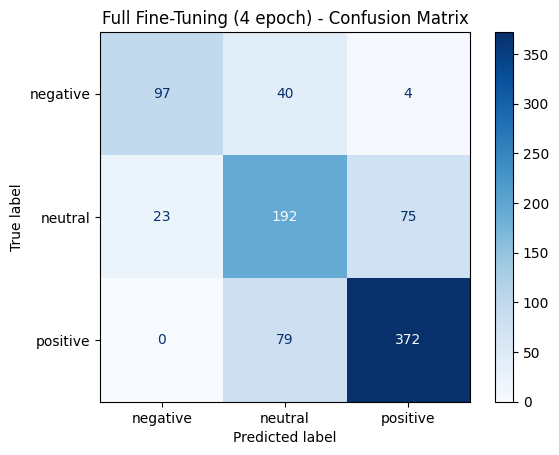

In [14]:
print_acc_and_confusion_matrix(true_labels_ft, pred_labels_ft)

- 일부 샘플에 대해 원문, 정답 라벨, 예측 라벨을 함께 출력해 모델이 잘 예측하는 패턴과 자주 헷갈리는 패턴(예: 중립 리뷰를 긍정으로 오분류)을  
직접 확인한다.

- 5장에서 Full Fine-Tuning과 PEFT 모델의 오류 유형을 비교할 때  정성적인 근거로 활용된다.

In [15]:
def print_samples(dataset, true_labels, pred_labels, num_samples=5):
    label_to_text = {0: "negative", 1: "neutral", 2: "positive"}

    print("\n[✅ 예측 성공 샘플]")
    correct_indices = [
        i for i, (pred, true) in enumerate(zip(pred_labels, true_labels)) if pred == true
    ]
    for i in correct_indices[:num_samples]:
        print("- 원문:", dataset[i]["text"])
        print("- 정답:", label_to_text[dataset[i]["label"]],
              "\n- 예측:", label_to_text[pred_labels[i].item()])
        print("-" * 40)

    print("\n[❌ 예측 실패 샘플]")
    wrong_indices = [
        i for i, (pred, true) in enumerate(zip(pred_labels, true_labels)) if pred != true
    ]
    for i in wrong_indices[:num_samples]:
        print("- 원문:", dataset[i]["text"])
        print("- 실제:", label_to_text[dataset[i]["label"]],
              "\n- 예측:", label_to_text[pred_labels[i].item()])
        print("-" * 40)

num_samples = 5
print_samples(dataset["test"], true_labels_ft, pred_labels_ft, num_samples)


[✅ 예측 성공 샘플]
- 원문: 이어폰을 새로 장만하게 되어서 케이스도 같이 구매했습니다!! 원래 케이스 안 끼고 그냥 쓸 생각이었는데 주변에서 케이스 사용하는게 훨씬 낫다고 해서 열심히 서칭 후 구매하게 되었네요 ㅋㅋ우선 색상 정말 맘에 듭니다~! 제가 원래 파스텔 톤을 좋아하는데 전 색상이 파스텔 톤임과 동시에 색상 선택폭도 엄청나게 넓어서 만족도가 짱짱 높았어요ㅋㅋㅋ그런데 방수 케이스라고 해놓고 방수는 잘 안되네요. 생활방수는 될 줄 알고 별 신경 안쓰고 사용했는데 물이 케이스 안에 있는 이어폰으로 좀 들어갈 때가 있었어요. 이럴거면 방수 케이스라고 하지 않고 그냥 케이스라고 하는게 나았을 것 같네요.
- 정답: neutral 
- 예측: neutral
----------------------------------------
- 원문: 좋은 무선 마우스를 산 줄 알았어요. 가끔은 저도 집에서 일을 해야 해서 나름 검색도 많이 하고 샀는데 수신센서가 안 좋은 건지 자꾸 탁탁 치게 되네요. 이거 곧 마우스 분해될 것 같아요.하자품인건지 원래 이런건지 알수가없네요.그냥 그런가부다 하고 씁니다. USB 수신기만 연결하면 AUTO LINK 자동 연결 되어 복잡한 과정없이 수신기를 연결할수 있어 자동으로 바로 사용이 가능해요. 전 스타일리쉬하고 세련되보이는 블랙을 선택했는데 정말 잘한것 같아요. 고급스러움이 넘치는것 같거든요. ^^ 다들 고급스러운 마우스 하나 장만 하세용. 강추합니다.
- 정답: neutral 
- 예측: neutral
----------------------------------------
- 원문: 얼마전 구매한 상품입니당ㅎㅎ일단 충전 어댑터는 재구매입니다. 처음에 OOO 무선 충전기와 어댑터 화이트를 깔맞춤으로 사서 아주 잘쓰고 있었죠, 어댑터만 출장중에 잃어버려서.성능에 아주 만족했었지만 고속충전 어댑터를 여러가지 제품들을 다시 서치했습니다. 그래도 구매버튼을 누르게 되는건 OOO 제품이더군요. 그 이유는1. 동일 사양에 양심적인 가격이

## 4. PEFT 기반 감성 분석 모델

### 4.1. PEFT(LoRA 등) 개념 및 적용 전략

- PEFT(Parameter-Efficient Fine-Tuning) 기법 중 하나인 LoRA를 적용하여, 적은 수의 파라미터만 학습하는 감성 분석 모델을 구성한다.

- LoRA는 베이스 모델의 가중치는 고정한 채, 특정 선형 계층에 저랭크 어댑터를 추가로 붙여 학습함으로써, 성능은 유지하면서도 학습 비용과 저장 용량을 크게 줄일 수 있다

### 4.2. PEFT 설정 및 베이스 모델 래핑

- KcELECTRA 분류 모델에 LoRA 어댑터를 삽입해 PEFT(LoRA) 기반 감성 분석 모델을 구성한다.

- self-attention의 query/key/value 및 출력 dense 계층 이름에 대응하는 선형층에만 LoRA를 적용해, 전체 파라미터 중 일부만 학습되도록 설정한다.

In [16]:
from peft import LoraConfig, get_peft_model, TaskType
from transformers import AutoModelForSequenceClassification

model_name = "beomi/KcELECTRA-base"

# 1) 베이스 모델 로드 (PEFT용)
base_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3,
).to(device)

# 2) LoRA 설정
lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["query", "key", "value", "dense"],  # attention 선형층에 LoRA 적용
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.SEQ_CLS,
)

# 3) LoRA 어댑터를 입힌 PEFT 모델 생성
model_peft = get_peft_model(base_model, lora_config)

# 학습 가능한 파라미터 수 확인
model_peft.print_trainable_parameters()

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,920,003 || all params: 111,003,654 || trainable%: 1.7297


### 4.3. PEFT 학습 설정 및 학습

- Full Fine-Tuning과 공정하게 비교하기 위해, PEFT 모델도 동일한 데이터셋과 배치 크기, 에포크 수(4 epoch)를 사용해 학습한다.

- 차이점은 KcELECTRA 전체가 아니라 LoRA 어댑터 파라미터만 업데이트된다는 점이다.

In [19]:
from transformers import TrainingArguments, Trainer
import evaluate

def create_peft_trainer(model, training_args):
    accuracy = evaluate.load("accuracy")

    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = torch.argmax(torch.tensor(logits), dim=1)
        return accuracy.compute(predictions=preds, references=labels)

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["validation"],
        compute_metrics=compute_metrics,
    )
    return trainer

num_epochs_peft = 4
batch_size_peft = 64

training_args_peft = TrainingArguments(
    output_dir="./results_peft",
    eval_strategy="epoch",
    logging_strategy="epoch",
    per_device_train_batch_size=batch_size_peft,
    per_device_eval_batch_size=batch_size_peft,
    num_train_epochs=num_epochs_peft,
    report_to="none",
)

In [20]:
trainer_peft = create_peft_trainer(model_peft, training_args_peft)

peft_train_output = trainer_peft.train()
peft_train_output

Epoch,Training Loss,Validation Loss,Accuracy
1,1.000400,0.993533,0.509915
2,0.894500,0.796116,0.611898
3,0.742700,0.736460,0.626062
4,0.708600,0.733144,0.685552


TrainOutput(global_step=200, training_loss=0.8365376281738282, metrics={'train_runtime': 2506.379, 'train_samples_per_second': 5.064, 'train_steps_per_second': 0.08, 'total_flos': 853574019213312.0, 'train_loss': 0.8365376281738282, 'epoch': 4.0})

### 4.4. PEFT 모델 평가 및 어댑터 저장

- 학습된 LoRA 어댑터만 따로 저장해 모델 크기를 비교할 수 있게 한다.

- 4 epoch로 학습한 LoRA 기반 PEFT 모델을 테스트 데이터 기준으로 평가하고, Full Fine-Tuning과 동일한 형식으로 테스트 정확도, 혼동 행렬, 예측 샘플을 출력한다.

- `어댑터 저장, 저장된 어댑터 재로드, 테스트셋 평가, 예측 샘플 분석` 순서로 Full Fine-Tuning과 동일한 형식으로 정리한다.

In [21]:
# LoRA 어댑터 저장

import shutil

def save_peft_adapter(model, tokenizer, adapter_path):
    # LoRA 어댑터 파라미터만 저장
    model.save_pretrained(adapter_path)
    tokenizer.save_pretrained(adapter_path)

    # 디렉터리를 zip으로 압축
    shutil.make_archive(adapter_path, "zip", adapter_path)
    print(f"{adapter_path}.zip 생성 완료")

save_peft_adapter(model_peft, tokenizer, "peft_lora_kcelectra_ep4")

peft_lora_kcelectra_ep4.zip 생성 완료


In [22]:
# 저장된 어댑터 로드

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from peft import PeftModel

base_model_name = "beomi/KcELECTRA-base"
adapter_path = "peft_lora_kcelectra_ep4"

# 베이스 모델 다시 로드
base_model_for_eval = AutoModelForSequenceClassification.from_pretrained(
    base_model_name,
    num_labels=3,
).to(device)

# 저장된 LoRA 어댑터 로드 및 결합
model_peft_loaded = PeftModel.from_pretrained(
    base_model_for_eval,
    adapter_path,
).to(device)
model_peft_loaded.eval()

# 토크나이저도 어댑터 디렉터리에서 로드 (필요 시)
tokenizer_peft = AutoTokenizer.from_pretrained(adapter_path)

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
# 테스트셋 정확도 및 혼동 행렬
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch

# 평가용 DataLoader (Full FT와 동일 형식)
eval_batch_size = 64
test_dataset_torch = tokenized_dataset["test"]

test_loader_peft = DataLoader(
    test_dataset_torch,
    batch_size=eval_batch_size,
    shuffle=False,
)

def predict_with_model(model, dataloader):
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
            )
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    return all_preds, all_labels

pred_labels_peft, true_labels_peft = predict_with_model(
    model_peft_loaded,
    test_loader_peft,
)

def print_acc_and_confusion_matrix(true_labels, pred_labels, title_suffix=""):
    test_accuracy = accuracy_score(true_labels, pred_labels)
    print(f"테스트 정확도{title_suffix}: {test_accuracy * 100:.2f}%")

    cm = confusion_matrix(true_labels, pred_labels)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=["negative", "neutral", "positive"],
    )
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"PEFT (LoRA, 4 epoch) - Confusion Matrix{title_suffix}")
    plt.show()

테스트 정확도: 68.59%


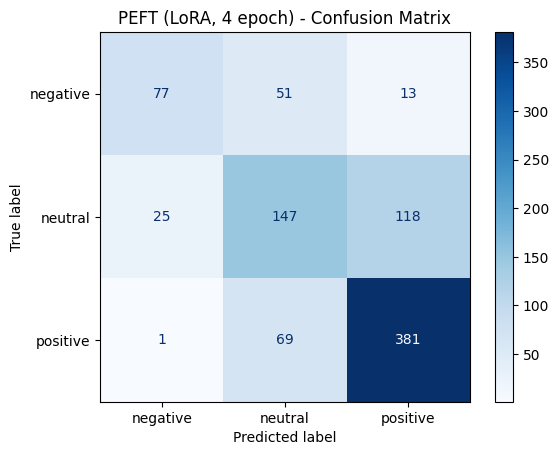

In [24]:
print_acc_and_confusion_matrix(true_labels_peft, pred_labels_peft)

In [25]:
def print_samples(dataset, true_labels, pred_labels, num_samples=5):
    label_to_text = {0: "negative", 1: "neutral", 2: "positive"}

    print("\n[✅ 예측 성공 샘플]")
    correct_indices = [
        i for i, (pred, true) in enumerate(zip(pred_labels, true_labels)) if pred == true
    ]
    for i in correct_indices[:num_samples]:
        print("- 원문:", dataset[i]["text"])
        print("- 정답:", label_to_text[dataset[i]["label"]],
              "\n- 예측:", label_to_text[pred_labels[i].item()])
        print("-" * 40)

    print("\n[❌ 예측 실패 샘플]")
    wrong_indices = [
        i for i, (pred, true) in enumerate(zip(pred_labels, true_labels)) if pred != true
    ]
    for i in wrong_indices[:num_samples]:
        print("- 원문:", dataset[i]["text"])
        print("- 실제:", label_to_text[dataset[i]["label"]],
              "\n- 예측:", label_to_text[pred_labels[i].item()])
        print("-" * 40)

num_samples = 5
print_samples(dataset["test"], true_labels_peft, pred_labels_peft, num_samples)


[✅ 예측 성공 샘플]
- 원문: 이어폰을 새로 장만하게 되어서 케이스도 같이 구매했습니다!! 원래 케이스 안 끼고 그냥 쓸 생각이었는데 주변에서 케이스 사용하는게 훨씬 낫다고 해서 열심히 서칭 후 구매하게 되었네요 ㅋㅋ우선 색상 정말 맘에 듭니다~! 제가 원래 파스텔 톤을 좋아하는데 전 색상이 파스텔 톤임과 동시에 색상 선택폭도 엄청나게 넓어서 만족도가 짱짱 높았어요ㅋㅋㅋ그런데 방수 케이스라고 해놓고 방수는 잘 안되네요. 생활방수는 될 줄 알고 별 신경 안쓰고 사용했는데 물이 케이스 안에 있는 이어폰으로 좀 들어갈 때가 있었어요. 이럴거면 방수 케이스라고 하지 않고 그냥 케이스라고 하는게 나았을 것 같네요.
- 정답: neutral 
- 예측: neutral
----------------------------------------
- 원문: 좋은 무선 마우스를 산 줄 알았어요. 가끔은 저도 집에서 일을 해야 해서 나름 검색도 많이 하고 샀는데 수신센서가 안 좋은 건지 자꾸 탁탁 치게 되네요. 이거 곧 마우스 분해될 것 같아요.하자품인건지 원래 이런건지 알수가없네요.그냥 그런가부다 하고 씁니다. USB 수신기만 연결하면 AUTO LINK 자동 연결 되어 복잡한 과정없이 수신기를 연결할수 있어 자동으로 바로 사용이 가능해요. 전 스타일리쉬하고 세련되보이는 블랙을 선택했는데 정말 잘한것 같아요. 고급스러움이 넘치는것 같거든요. ^^ 다들 고급스러운 마우스 하나 장만 하세용. 강추합니다.
- 정답: neutral 
- 예측: neutral
----------------------------------------
- 원문: 얼마전 구매한 상품입니당ㅎㅎ일단 충전 어댑터는 재구매입니다. 처음에 OOO 무선 충전기와 어댑터 화이트를 깔맞춤으로 사서 아주 잘쓰고 있었죠, 어댑터만 출장중에 잃어버려서.성능에 아주 만족했었지만 고속충전 어댑터를 여러가지 제품들을 다시 서치했습니다. 그래도 구매버튼을 누르게 되는건 OOO 제품이더군요. 그 이유는1. 동일 사양에 양심적인 가격이

- 동일한 데이터셋과 4 epoch 설정으로 LoRA 기반 PEFT 모델을 학습한 결과
    - validation accuracy는 epoch 4 기준 약 0.69 수준으로 Full Fine-Tuning보다 다소 낮게 나타났다.

- 이후 4.4와 5장에서는 이 **4 epoch PEFT 모델**을 Full Fine-Tuning baseline과 비교하여 테스트셋 성능과 모델 크기 관점에서 PEFT의 장단점을 살펴본다.

## 5. 실험 결과 비교 및 분석

### 5.1. 학습 시간·성능·모델 크기 비교 표

| 모델                         | Epoch | Val Acc | Test Acc | 학습 시간(4ep)        | 모델 크기 (zip) |
|------------------------------|-------|---------|----------|------------------------|-----------------|
| Full Fine-Tuning (baseline)  | 4     | 0.759   | 0.749    | 약 2시간 20분 수준     | 386 MB          |
| PEFT (LoRA, attention only)  | 4     | 0.686   | 0.686    | 약 40분 수준           | 7.24 MB         |

- Full FT가 검증·테스트 정확도에서 약 6~7%p 정도 우위에 있다.

- PEFT는 학습 시간이 4ep 기준 약 3배 이상 짧고, 모델 크기는 약 53배(386MB → 7.24MB) 작다.

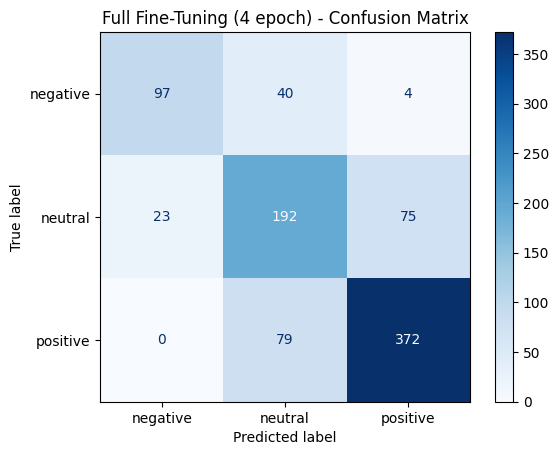
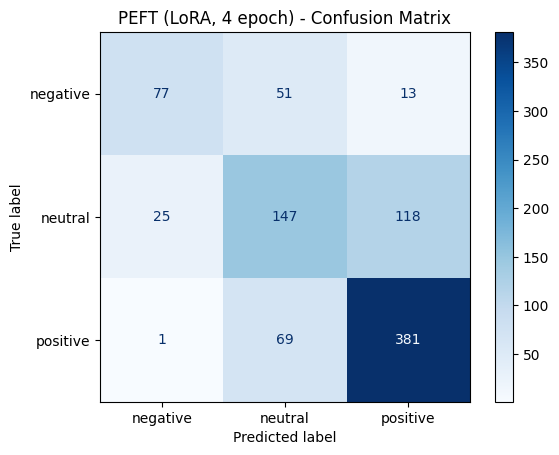

### 5.2. 결과 해석 및 장단점 분석

- 성능 측면
    - Full FT: KcELECTRA 전체 파라미터를 업데이트한 덕분에 검증/테스트 정확도가 가장 높다.  
        \*특히 중립(neutral) 클래스에서 PEFT보다 오분류가 적다(혼동행렬에서 확인).
    - PEFT: 같은 데이터·에포크에서도 정확도가 약 6.4%p 낮지만, 긍/부정 판별 경향은 비슷하게 따라간다.

- 효율성 측면
    - Full FT: 학습·저장 비용이 크고, 자원 요구가 높다.(5ep 에서 OOM 발생)
    - PEFT: LoRA 어댑터만 학습·저장하기 때문에 학습 시간이 짧고, 저장 용량이 극단적으로 작아 배포·버전 관리에 유리하다.

- 트레이드오프 정리
    - 이번 실험에서는 “정확도 약 6.4%p 감소”와 맞바꾸고 모델 크기 약 50배 감소를 얻은 셈이다.
    - 따라서 정확도가 최우선인 환경이라면 Full FT, GPU·스토리지 제약이 큰 환경이라면 PEFT가 더 적합한 선택지가 된다.

### 5.3. 한계점 및 추가 실험 아이디어

- 한계점
    - 에포크 수·학습률 등 하이퍼파라미터를 충분히 탐색하지 못하고, Full FT와 PEFT 에서 “4 epoch, 기본 LR” 한 가지 설정에 가까운 실험만 수행했다.
    - LoRA 적용 대상도 self-attention 선형층으로 고정했기 때문에,FFN이나 다른 모듈에 대한 조합은 검증하지 못했다.
    - 데이터 전처리(노이즈 제거, 길이 필터링 등)에 대한 실험도 제한적이었다.

- 추가 실험 아이디어
    - Full FT / PEFT 모두에 대해 학습률 스케줄·에포크 수를 더 세밀하게 바꿔 보며 “같은 자원 안에서 얻을 수 있는 최선의 점”을 탐색
    - LoRA의 r, alpha, target_modules를 바꿔 보며 “정확도 손실은 줄이면서, 파라미터 수를 얼마나 더 줄일 수 있는지” 확인
    - 감성 분석 외의 태스크(예: 카테고리 분류)에 같은 세팅을 적용해 “PEFT가 태스크 전체에서 일관되게 유리한지” 검증

### 5.4. 결론

- 이번 실험에서는 KcELECTRA를 대상으로 Full Fine-Tuning과 LoRA 기반 PEFT를 비교한 결과, Full FT가 약간 더 높은 정확도를 제공하는 대신, 학습 시간과 GPU·저장 자원 측면에서 훨씬 비효율적이라는 점이 확인되었다.

- 반대로 PEFT는 테스트 정확도가 약 6%p 정도 낮아지는 한계가 있지만, 모델 크기를 약 50배(386MB → 7.24MB)까지 줄이고 학습 시간도 크게 단축할 수 있어,
“공개된 오픈소스 베이스 모델을 그대로 두고, 제한된 자원 안에서 필요한 부분만 효율적으로 미세조정하는 전략”에 특히 적합해 보인다.

- 따라서 실무 관점에서는 정확도를 극대화해야 하는 일부 상황을 제외하면, 대부분의 감성 분석·서비스형 NLP 작업에서 풀 파인튜닝을 기본으로 하기보다는, 가용한 자원 범위 내에서 PEFT(특히 LoRA)를 우선적으로 검토하는 것이 더 현실적인 선택이라 결론지을 수 있다.